# Counterflow Laminar Diffusion Flame


This Jupyter Notebook was written by Dan Haworth. It was adapted from the Cantera Python example "diffusion_flame.py" under "One-Dimensional Flames" at https://cantera.org/examples/python/index.html. This is intended as a tutorial to be used in parallel with Chapter 9 of the book "An Introduction to Combustion: Concepts and Applications" by Stephen R. Turns and Daniel C. Haworth. That book is referred to as "Turns 4th ed." throughout this Notebook.

This Notebook was last updated 20 February 2020.

The objectives of this tutorial are to review a basic configuration that is widely used in experimental and modeling studies of  laminar diffusion flames -- a steady counterflow laminar diffusion flame -- and to show how to simulate such flames using Cantera. The influences of strain rate and radiative heat transfer are demonstrated and discussed. The concept of a mixture fraction is reviewed, and the flame structure is explored in both physical space and in mixture-fraction space. The influence of differential species diffusion on mixture fractions is shown. We will use the thermodynamic properties, reaction mechanism, and molecular transport properties that are included in gri30.cti.

The reader should be familiar with the material in the Chapter 8 Notebooks before working through this Notebook.

## 1. Physical configuration

The configuration is shown in Figure 9.15 of Turns 4th ed. Two opposing axisymmetric jets are aligned so that they share a common axis of symmetry, and the jets are aimed directly at each other. The system is two-dimensional (axisymmetric) and steady. A coordinate system is defined where the axial distance from the fuel nozzle exit is denoted as $x$ in Figure 9.15 (or as $z$ in Cantera -- we will use $z$ to denote the axial spatial coordinate in the remainder of this Notebook) and the radial distance from the axis of symmetry is denoted as $r$. 

The fluid dynamics are such that a *stagnation plane* (a plane on which the axial velocity component is equal to zero) is located between the two nozzles, at a particular value of $z$ that depends on the relative momentum fluxes from the two nozzles. The *stagnation streamline* is a streamline along the axis of symmetry that intersects the stagnation plane at the *stagnation point*, where all components of velocity are equal to zero. For the case where a flame is present, the flame (defined by the location where fuel and oxidizer are locally in stoichiometric proportion) is parallel to the stagnation plane. The flame can be on either side of the stagnation plane. However, for the case of a pure hydrocarbon fuel jet and a pure air oxidizer jet, the flame generally lies on the oxidizer side of the stagnation plane, as discussed in Chapter 9 and shown in Figure 9.15.

In this configuration, diffusive molecular transport is superposed on convective transport by the local mixture flow velocity. Fuel diffuses toward the flame from the fuel-nozzle (fuel-rich) side, and oxidizer diffuses toward the flame from the oxidizer-nozzle (fuel-lean) side. Products of combustion that are formed in the reaction zone diffuse away from the flame in both directions.

As discussed in Chapter 9 of Turns 4th ed., the problem can be recast as a steady one-dimensional problem to solve for the spatial structure of the flame along the stagnation streamline, with boundary conditions prescribed at the fuel and oxidizer nozzle exits. The governing equations are given in Chapter 9. As was the case in our earlier study of laminar premixed flames, we do not need to specify the equations explicitly to solve the problem using Cantera. Rather, we can use predefined Cantera objects that effectively do that for us. 

## 2. Cantera model

Here we consider a flame in which a fuel jet of pure ethane (C2H6) impinges on an oxidizer jet of pure air, using our standard approximation for air. The pressure is uniform and constant, and is equal to atmospheric pressure. This example can serve as a starting point to set up Cantera for other counterflow laminar diffusion flame problems.

In [1]:
# import modules
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import time

# print Cantera version
print("Running Cantera version: {}".format(ct.__version__))

Running Cantera version: 2.4.0


In [2]:
# define the gas mixture
# here we use the thermodynamic properties, reaction mechanism, and molecular transport properties from gri30.cti
gas = ct.Solution('gri30.cti')

In [3]:
# specify the thermochemical states and mass flow rates per unit area of the mixtures exiting from the two nozzles

# pressure (constant and uniform)
P = ct.one_atm  # (Pa)

# fuel-nozzle exit temperature, composition, and mass flux (mass flow rate per unit area)
T_fuel    = 300.0              # (K)
X_fuel    = 'C2H6:1.0'         # species mole fractions
mdot_fuel = 0.24               # (kg/m^2-s)

# oxidizer-nozzle exit temperature, composition, and mass flux (mass flow rate per unit area)+
T_oxid    = 300.0              # (K)
X_oxid    = 'O2:0.21, N2:0.79' # species mole fractions
mdot_oxid = 0.72               # (kg/m^2-s)

# distance between the fuel- and oxidizer-nozzle exit planes
width = 0.02 # (m)

We will use Cantera's [`CounterflowDiffusionFlame()`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/onedim.html#counterflowdiffusionflame) class to define the flame. As was the case for the laminar premixed flames considered earlier, many options can be specified regarding the physical system, the numerical methods that are used to solve the problem, and solution accuracy tolerances. Here a base set of parameters is provided, which can be used as an initial set to try in other counterflow laminar diffusion flame simulations. Default values are accepted for all parameters for which values are not explicitly given. 

As was the case for the one-dimensional laminar premixed flames, the governing equations are discretized using a one-dimensional grid in the $z$ direction. An initially coarse grid is successively refined until either a steady-state solution is found that meets the prescribed accuracy requirements, or the numerical solution fails with an error. In contrast to the laminar premixed flames, here the extent of the computational domain ("width") is fixed, and corresponds to the given physical distance between the fuel and oxidizer nozzle exits.

In [4]:
# create the flame object by filling the computational domain with the desired gas mixture
flame = ct.CounterflowDiffusionFlame(gas, width=width)

# set the boundary conditions
# the fuel nozzle exit corresponds to the z=0 boundary of the computational domain
# the oxider nozzle exit corresponds to the z=width boundary of the computational domain
flame.fuel_inlet.T        = T_fuel
flame.fuel_inlet.X        = X_fuel
flame.fuel_inlet.mdot     = mdot_fuel

flame.oxidizer_inlet.T    = T_oxid
flame.oxidizer_inlet.X    = X_oxid
flame.oxidizer_inlet.mdot = mdot_oxid

# radiative heat transfer to the boundaries of the computational domain can be considered, if desired
# for now, we will turn off radiation
# set the boundary emissivities to zero
flame.set_boundary_emissivities(0.0, 0.0)
# disable radiation
flame.radiation_enabled = False

# specify numerical parameters that control local grid refinement
# by default, the code will start with a coarse uniform grid
# it will then successively refine the grid, inserting more grid points locally in regions where the solution varies
#   rapidly in space
# some prior experience can be helpful to determine appropriate values
# you can experiment to see what happens if you change these values
flame.set_refine_criteria(ratio=4, slope=0.2, curve=0.3, prune=0.04)

# specify the level of output desired
# loglevel = 1 is appropriate, for current purposes
# you can decrease/increase the value of loglevel to see less/more detailed output
# valid values for loglevel are 0 (no output) to 5 (most detailed output)
loglevel = 1

Let's look at some of the initial conditions:

In [5]:
# print the initial computational grid
flame.grid

array([0.   , 0.004, 0.008, 0.012, 0.016, 0.02 ])

There are six uniformly spaced grid points initially.

In [6]:
# print the initial temperature profile
flame.T

array([300., 300., 300., 300., 300., 300.])

The initial temperature profile is uniform, at a temperature that is equal to the current temperature of the gas mixture.

In [7]:
# print the initial velocity profile
flame.u

array([0., 0., 0., 0., 0., 0.])

The initial flow speed is equal to zero everywhere.

In [8]:
# print the initial C2H6 mole fraction profile
flame.X[gas.species_index('C2H6')]

array([0., 0., 0., 0., 0., 0.])

In [9]:
# print the initial H2 mole fraction profile
flame.X[gas.species_index('H2')]

array([1., 1., 1., 1., 1., 1.])

Why is the computational domain filled with H2? Because at this point, we have not reset "gas" to anything different from its default initial thermochemical state. To see this:

In [10]:
# print the current state of the gas mixture
gas()


  gri30:

       temperature             300  K
          pressure          101325  Pa
           density       0.0818891  kg/m^3
  mean mol. weight         2.01588  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy           26470        5.336e+04     J
   internal energy     -1.2109e+06       -2.441e+06     J
           entropy           64914        1.309e+05     J/K
    Gibbs function     -1.9448e+07        -3.92e+07     J
 heat capacity c_p           14312        2.885e+04     J/K
 heat capacity c_v           10187        2.054e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                H2              1                1         -15.7173
     [  +52 minor]              0                0



Before we continue, let's compute the constant-pressure adiabatic flame temperature and equilibrium NO mole fraction corresponding to a stoichiometric mixture of C2H6 and air, initially at 300 K and 1 atm. This will be useful in what follows:

In [11]:
# set the thermochemical state to correspond to a stoichiometric mixture of C2H6 and air at 300 K and 1 atm
gas.TP = 300. , P
gas.set_equivalence_ratio(1.0, 'C2H6','O2:1.0, N2:3.76')

# compute the corresponding constant-pressure adiabatic equilbrium state
gas.equilibrate('HP')

# save the equilibrium temperature and equilibrium NO mole fraction
T_eq  = gas.T
NO_eq = gas.X[gas.species_index('NO')]

# print the equilibrium temperature and equilibrium NO mole fraction
T_eq, NO_eq

(2259.5981704564383, 0.0022545295013719656)

The constant-pressure adiabatic flame temperature is approximately 2260 K. We expect that this will be the upper limit for the temperature at any location in our flame, since the pressure is equal to 1 atm and both the fuel and the oxidizer jets are at 300 K. The equilibrium NO mole fraction is approximately 0.002255, or 2255 ppm.

Now let's solve for the steady-state flame structure, and time how long it takes to do that. Internally, the code computes appropriate initial guesses for the temperature and species profiles, based on the given boundary conditions. It then continues to refine the grid and to compute until either a steady state solution is found that satisfies the given accuracy requirements (recall that we have accepted default values for most numerical parameters) or the numerical solution exits with an error. Note that the same `solve()` function is used here as was used earlier for laminar premixed flames.

In principle, the steady-state solution should be independent of the specification of the initial conditions. However, a good guess for the initial conditions can reduce the computational time that is needed to find the steady state, and a bad guess for the initial conditions may result in a convergence failure.

In [12]:
# for "auto=True", the code will sequentially execute the default solution stages, and will attempt to recover from any
#   errors that are encountered

ctim0 = time.time()

# solve for the steady-state flame structure
flame.solve(loglevel=loglevel, auto=True)

ctim1 = time.time()
ctime = ctim1 - ctim0

# print the computational time required
print(" ")
print("Solution required {:.2f} s".format(ctime))


************ Solving on 6 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      2.67e-06      7.026
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     4.561e-05      5.557
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0007794       5.17
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      0.005918      3.774
Attempt Newton solution of steady-state problem...    success.

Problem solved on [6] point grid(s).

..............................................................................
grid refinement disabled.

******************** Solving with grid refinement enabled ********************

..............................................................................
Attempt Newton solution of steady-state probl

You can scroll through the output above to monitor the progress of the numerical solution. The computational time required is on the order of 10-20 seconds, depending on your computer, and the final grid has approximately 100 nonuniformly spaced grid points:

In [13]:
# print the final grid
flame.grid

array([0.        , 0.001     , 0.002     , 0.0025    , 0.003     ,
       0.00325   , 0.0035    , 0.003625  , 0.00375   , 0.0038125 ,
       0.003875  , 0.004     , 0.0040625 , 0.004125  , 0.0041875 ,
       0.00425   , 0.0043125 , 0.004375  , 0.0044375 , 0.0045    ,
       0.004625  , 0.00475   , 0.004875  , 0.005     , 0.005125  ,
       0.00525   , 0.005375  , 0.0054375 , 0.0055    , 0.0055625 ,
       0.005625  , 0.0056875 , 0.00575   , 0.0058125 , 0.005875  ,
       0.0059375 , 0.006     , 0.0060625 , 0.00609375, 0.006125  ,
       0.00615625, 0.0061875 , 0.00621875, 0.00625   , 0.00628125,
       0.0063125 , 0.00634375, 0.006375  , 0.00640625, 0.00642188,
       0.0064375 , 0.00645313, 0.00646875, 0.00648438, 0.0065    ,
       0.00653125, 0.0065625 , 0.00659375, 0.006625  , 0.0066875 ,
       0.00675   , 0.0068125 , 0.006875  , 0.0069375 , 0.007     ,
       0.0070625 , 0.007125  , 0.0071875 , 0.00725   , 0.0073125 ,
       0.007375  , 0.0074375 , 0.0075    , 0.0075625 , 0.00762

## 3. Flame structure in physical space

The flame structure in physical space is examined by printing and/or plotting the computed steady-state profiles of temperature and species composition as functions of $z$:

In [14]:
# print the steady-state temperature profile
flame.T

array([ 300.        ,  300.00942794,  300.18731395,  301.24270497,
        308.43562313,  323.13994444,  358.98910079,  389.589877  ,
        430.01682857,  453.75699   ,  479.68288394,  537.05696826,
        567.95911586,  600.16343835,  633.49051301,  667.77530026,
        702.86405524,  738.61178579,  774.88052617,  811.53843608,
        885.65223363,  959.85212164, 1033.35248631, 1105.62821574,
       1176.52115956, 1246.4611321 , 1316.66534678, 1352.67370137,
       1389.59140514, 1427.75937272, 1467.50630732, 1509.11068251,
       1552.75097369, 1598.44419973, 1645.98003665, 1694.8691234 ,
       1744.32810865, 1793.30712149, 1817.13477358, 1840.33589666,
       1862.71020517, 1884.04297326, 1904.09980998, 1922.61831376,
       1939.29740141, 1953.78876581, 1965.70153063, 1974.63928441,
       1980.28866669, 1981.83803635, 1982.55301992, 1982.47074873,
       1981.64759157, 1980.15461309, 1978.07113619, 1972.37824596,
       1965.18573767, 1956.84279404, 1947.52558646, 1926.17096

The maximum temperature is approximately 1985 K, which is more than 270 K lower than the adiabatic flame temperature. (Note: Your computed peak temperature may be as much as 5 K or more different from this value, depending on the Cantera version and computer used.) In this configuration, the relative rates of chemical reactions, convection, and molecular transport influence the peak temperature. As we will see later, the maximum temperature will increase toward the adiabatic flame temperature as we decrease the mass flow rates of the reactants, and the maximum temperature will decrease as we increase the mass flow rates of the reactants.

The full solution (spatial profiles of velocity, temperature, species mass fractions, and some other quantitites) along the stagnation streamline can be displayed using `show_solution()`. As noted earlier, the axial spatial coordinate is denoted as 'z' (m), where $z$=0 corresponds to the fuel-nozzle exit and $z$=width corresponds to the oxidizer-nozzle exit. The radial velocity gradient is denoted as 'V' (1/s). Mixture composition is reported in terms of species mass fractions.

In [15]:
# display the steady-state solution
flame.show_solution()



>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> fuel_inlet <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

    Mass Flux:         0.24 kg/m^2/s 
    Temperature:        300 K 
    Mass Fractions: 
                    C2H6           1 



>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> flame <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

    Pressure:   1.013e+05 Pa

-------------------------------------------------------------------------------
          z           u           V           T      lambda      eField 
-------------------------------------------------------------------------------
          0      0.1965  -1.335e-19         300       -2653           0 
      0.001      0.1855       11.05         300       -2653           0 
      0.002      0.1528       22.12       300.2       -2653           0 
     0.0025      0.1288        27.7       301.2       -2653           0 
      0.003      0.1017       33.55       308.4       -2653           0 
    0.00325     0.08923       36.99       323.1       -2653           0 
     0.0035

   0.006406   0.0001857   9.306e-09   1.797e-07   1.496e-07   1.602e-07 
   0.006422   0.0001895   1.075e-08   1.784e-07   1.467e-07   1.555e-07 
   0.006438   0.0001931   1.238e-08   1.774e-07   1.426e-07   1.482e-07 
   0.006453   0.0001965   1.419e-08   1.768e-07   1.375e-07   1.387e-07 
   0.006469   0.0001995   1.617e-08   1.766e-07   1.312e-07   1.275e-07 
   0.006484   0.0002021   1.831e-08    1.77e-07    1.24e-07   1.152e-07 
     0.0065   0.0002042   2.058e-08   1.778e-07   1.161e-07   1.027e-07 
   0.006531   0.0002069   2.545e-08   1.815e-07   9.879e-08   7.822e-08 
   0.006563   0.0002076   3.062e-08   1.881e-07    8.15e-08   5.704e-08 
   0.006594   0.0002065   3.594e-08    1.98e-07    6.58e-08   4.005e-08 
   0.006625    0.000204   4.131e-08   2.111e-07   5.252e-08   2.715e-08 
   0.006688   0.0001957   5.207e-08   2.471e-07   3.453e-08   1.187e-08 
    0.00675   0.0001853   6.278e-08    2.93e-07   2.427e-08   4.815e-09 
   0.006813   0.0001741   7.367e-08   3.464e-07   1

You can scroll down through the output window above to examine the solution. The solution also can be saved to a .xml file and/or to an Excel-compatible .csv file:

In [16]:
# save the solution to a .xml file
flame.save('c2h6_CLDF.xml')

# save the solution to an Excel-compatible .csv file
# note that the compositions in the .csv file are reported in terms of species mole fractions, rather than mass fractions
flame.write_csv('c2h6_CLDF.csv', quiet=False)

Solution saved to file c2h6_CLDF.xml as solution solution.
Solution saved to 'c2h6_CLDF.csv'.


Information about the internal numerical steps that were taken to solve the problem also can be displayed:

In [17]:
# report some information about the internal solution procedure
flame.show_stats(0)


Statistics:

 Grid   Timesteps  Functions      Time  Jacobians      Time
    8           0        702        NA         31        NA
   13          40        879        NA         28        NA
   20          30        567        NA         15        NA
   29          30        366        NA         13        NA
   41          20        210        NA          7        NA
   61          10         95        NA          4        NA
   87           0         12        NA          1        NA
   96           0          8        NA          1        NA
  100           0          8        NA          1        NA


Now let's look at the computed steady-state spatial profiles of various quantities along the stagnation streamline. The figures below can be compared with Figures 9.16 and 9.17 in Turns 4th ed. (there for a CH4-air flame).

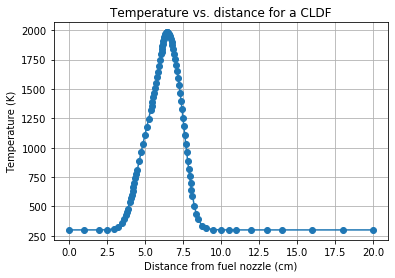

In [18]:
# plot the steady-state temperature profile
fig, ax = plt.subplots()
ax.plot(flame.grid*1000., flame.T, '-o', label='T')
ax.set(xlabel='Distance from fuel nozzle (cm)',
       ylabel='Temperature (K)',
       title ='Temperature vs. distance for a CLDF')
ax.grid(True)
#ax.legend(handlelength=4,loc='best')
fig.savefig("T_vs_z_CLDF.pdf")

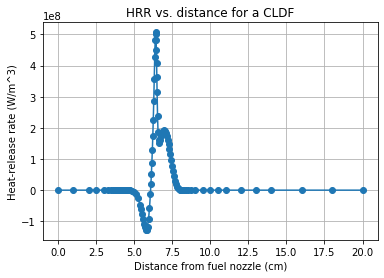

In [19]:
# plot the steady-state heat-release-rate profile
fig, ax = plt.subplots()
ax.plot(flame.grid*1000., flame.heat_release_rate, '-o', label='HRR')
ax.set(xlabel='Distance from fuel nozzle (cm)',
       ylabel='Heat-release rate (W/m^3)',
       title ='HRR vs. distance for a CLDF')
ax.grid(True)
#ax.legend(handlelength=4,loc='best')
fig.savefig("HRR_vs_z_CLDF.pdf")

The grid spacing (distance between adjacent symbols in the figures) is coarser near the fuel and oxidizer nozzle exits, and is finer in the flame zone, where spatial gradients in temperature and heat-release rate are the steepest.

Note the spatial location of the peak temperature; it is closer to the fuel nozzle than to the oxidizer nozzle. Recall that the oxidizer mass flow rate was specified to be three times the fuel mass flow rate here. 

The width of the zone of elevated temperature is several centimeters. This is much wider then the laminar premixed flame thickness for a stoichiometric ethane-air flame with the reactants at 300 K and 1 atm. The main peak in the heat-release-rate profile is much narrower, though. Note the negative peak in heat-release rate on the fuel-rich side of the flame. The initial fuel-breakdown reactions are endothermic. 

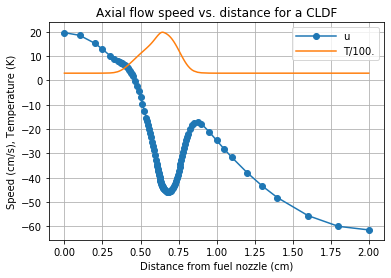

In [20]:
# plot the steady-state axial velocity profile
# also replot the temperature, for reference
fig, ax = plt.subplots()
ax.plot(flame.grid*100., flame.u*100., '-o', label='u'     )
ax.plot(flame.grid*100., flame.T/100.,       label='T/100.')
ax.set(xlabel='Distance from fuel nozzle (cm)',
       ylabel='Speed (cm/s), Temperature (K)',
       title ='Axial flow speed vs. distance for a CLDF')
ax.grid(True)
ax.legend(handlelength=4,loc='best')
fig.savefig("u_vs_z_CLDF.pdf")

Velocities in the direction from the fuel nozzle toward the oxidizer nozzle are positive, and velocities toward the fuel nozzle are negative. For the conditions specified, the stagnation plane (where u=0) is closer to the fuel nozzle than to the oxidizer nozzle, and the peak temperature is on the oxidizer side of the stagnation plane. The "bump" in the velocity profile is a consequence of volume expansion in the hot flame zone. Note that the peak temperature location corresponds (to a good approximation) with the location of the local minimum in axial velocity.

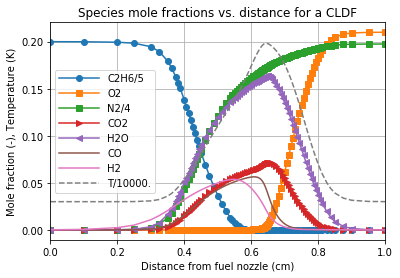

In [21]:
# plot steady-state major-species mole-fraction profiles, plus CO and H2
# also replot the temperature, for reference
# scale each quantity so that all can be seen clearly
X_C2H6 = flame.X[gas.species_index('C2H6')]
X_O2   = flame.X[gas.species_index('O2')]
X_N2   = flame.X[gas.species_index('N2')]
X_CO2  = flame.X[gas.species_index('CO2')]
X_H2O  = flame.X[gas.species_index('H2O')]
X_CO   = flame.X[gas.species_index('CO')]
X_H2   = flame.X[gas.species_index('H2')]

fig, ax = plt.subplots()
ax.plot(flame.grid*100., X_C2H6/5.,      '-o',   label='C2H6/5'  )
ax.plot(flame.grid*100., X_O2,           '-s',   label='O2'      )
ax.plot(flame.grid*100., X_N2/4.,        '-s',   label='N2/4'    )
ax.plot(flame.grid*100., X_CO2,          '->',   label='CO2'     )
ax.plot(flame.grid*100., X_H2O,          '-<',   label='H2O'     )
ax.plot(flame.grid*100., X_CO,                   label='CO'      )
ax.plot(flame.grid*100., X_H2,                   label='H2'      )
ax.plot(flame.grid*100., flame.T/10000., '--',   label='T/10000.')
ax.set(xlim=(0.0,1.0),
       xlabel='Distance from fuel nozzle (cm)',
       ylabel='Mole fraction (-), Temperature (K)',
       title ='Species mole fractions vs. distance for a CLDF')
ax.grid(True)
ax.legend(handlelength=4,loc='best')
fig.savefig("Xmajor_vs_z_CLDF.pdf")

The structure is qualitatively consistent with the comments in Section 1 above. The flame is defined as being centered at the location at which fuel and oxidizer are locally in stoichiometric proportion; this will become clearer when we get to Section 5 below. Fuel diffuses toward the flame from the fuel-rich side, oxidizer diffuses toward the flame from the fuel-lean side, and products diffuse away from the flame in both directions. There is some overlap of C2H6 and O2 (this would be clearer on zooming in), and N2 from the oxidizer jet diffuses across the flame into the fuel-rich side. The peak values of the major products CO2 and H2O are at a spatial location that is close to that of the peak temperature, while CO and H2 peak on the fuel-rich side. 

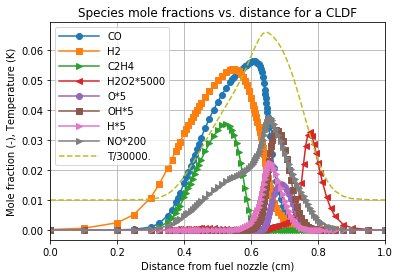

In [22]:
# plot steady-state minor-species mole-fraction profiles, including NO
# also replot the temperature, for reference
# scale each quantity so that all can be seen clearly
X_CO    = flame.X[gas.species_index('CO')]
X_H2    = flame.X[gas.species_index('H2')]
X_C2H4  = flame.X[gas.species_index('C2H4')]
X_H2O2  = flame.X[gas.species_index('H2O2')]
X_OH    = flame.X[gas.species_index('OH')]
X_O     = flame.X[gas.species_index('O')]
X_H     = flame.X[gas.species_index('H')]
X_NO    = flame.X[gas.species_index('NO')]

fig, ax = plt.subplots()
ax.plot(flame.grid*100., X_CO,           '-o', label='CO'       )
ax.plot(flame.grid*100., X_H2,           '-s', label='H2'       )
ax.plot(flame.grid*100., X_C2H4,         '->', label='C2H4'     )
ax.plot(flame.grid*100., X_H2O2*5000.,   '-<', label='H2O2*5000')
ax.plot(flame.grid*100., X_O*5.,         '-o', label='O*5'      )
ax.plot(flame.grid*100., X_OH*5.,        '-s', label='OH*5'     )
ax.plot(flame.grid*100., X_H*5.,         '->', label='H*5'      )
ax.plot(flame.grid*100., X_NO*200.,      '->', label='NO*200'   )
ax.plot(flame.grid*100., flame.T/30000., '--', label='T/30000.' )

ax.set(xlim  =(0.0,1.0),
       xlabel='Distance from fuel nozzle (cm)',
       ylabel='Mole fraction (-), Temperature (K)',
       title ='Species mole fractions vs. distance for a CLDF')
ax.grid(True)
ax.legend(handlelength=4,loc='best')
fig.savefig("Xminor_vs_z_CLDF.pdf")

The peaks in CO and H2 on the fuel-rich side are more evident here.

Recall that C2H4 (ethylene) is an olefin: a molecule with a double carbon-carbon bond. As we have seen earlier, such molecules are key intermediates in the oxidation of paraffin fuels. 

Note that different species peak at different spatial locations, with respect to the peak temperature. H2O2 peaks on the fuel-lean side. Peak OH, O, and H are slighly to the right (fuel-lean side) of the temperature peak. CO, H2, and C2H4 peak on the fuel-rich side. The NO peak is at approximately the same spatial location as the temperature peak.

We could look at other intermediates, including other hydrocarbon fragments, CHO, etc.

## 4. Strain rate

For some purposes, it is useful to characterize the influence of hydrodynamics (fluid mechanics) on flames in terms of strain rates (velocity gradients). For the counterflow configuration, this is usually done in terms of the axial strain rate along the stagnation streamline: du/dz, using the current notation. Changing the strain rate changes the relative rates of transport verus chemical reactions. 

We can use numpy's `gradient()` function to compute the axial strain rate as a function of distance from the fuel nozzle z:

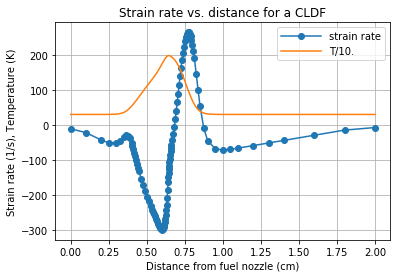

In [23]:
# plot the steady-state axial-strain-rate profile
# also replot the temperature, for reference
fig, ax = plt.subplots()
ax.plot(flame.grid*100., np.gradient(flame.u,flame.grid), '-o', label='strain rate')
ax.plot(flame.grid*100., flame.T/10.,                           label='T/10.'      )

ax.set(xlabel='Distance from fuel nozzle (cm)',
       ylabel='Strain rate (1/s), Temperature (K)',
       title ='Strain rate vs. distance for a CLDF')
ax.grid(True)
ax.legend(handlelength=4,loc='best')
fig.savefig("dudz_vs_z_CLDF.pdf")

The strain rate varies significantly, and nonmonotonically, along the stagnation streamline.

The location of the peak temperature coincides (to a good approximation) with the location of the maximum magnitude (minimum value) of the strain rate. 

It is desirable to use a single value of the strain rate to characterize the flame. For that purpose, there are several options. The [`strain_rate()`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/onedim.html#cantera.CounterflowDiffusionFlame.strain_rate) attribute can be used to access directly the mean value of the strain rate, the maximum value of the strain rate, or the value of the strain rate at the location where the reactants are locally in stoichiometric proportion. The latter requires specification of the fuel and oxidizer compositions. The value of the axial strain rate at the location where fuel and oxidizer are locally in stoichiometric proportion is the value that is probably most often used to characterize the strain rate of a counterflow laminar diffusion flame. That is appropriate, as the flame is usually defined as being located at that position.

In [24]:
# compute and print the mean, maximum, and stoichiometric strain rate values
# note that for the purposes of calculating the stoichiometric value, the oxidizer is specified as being O2
a_mean   = flame.strain_rate('mean')
a_max    = flame.strain_rate('max')
a_stoich = flame.strain_rate('stoichiometric', fuel='C2H6', oxidizer='O2')

a_mean, a_max, a_stoich

(40.54299549841865, 300.0451105069126, 298.8510383130254)

Note that strain rate magnitudes are reported, not their signed values. For example, 'max' returns the maximum strain rate magnitude, and this actually corresponds to a negative value of the local strain rate. The maximum strain rate magnitude occurs at a location that is close to the location where fuel and oxidizer are locally in stoichiometric proportion. This is usually the case, in this configuration.

We will return to a discussion of how flame structure varies with strain rate, after reviewing mixture fractions and looking at the flame structure in mixture-fraction space.

## 5. Mixture fractions, differential diffusion, and flame structure in mixture-fraction space

As discussed in Chapters 7 and 9 of Turns 4th ed., the structure of a diffusion flame is often conveniently described in terms of a mixture fraction. Mixture fractions were the subject of Cantera tutorial Notebook 7_2_Mixture_fractions. As we saw there, mixture fraction and equivalence ratio are closely related quantities. Compared to our earlier discussion of mixture fractions, a new consideration here is the influence of differential species diffusion.

### 5.1 Mixture fractions and differential diffusion

In the counterflow configuration, a mixture fraction is conventionally defined such that the local value of the mixture fraction corresponds to the local mass fraction of mixture that originated from the fuel nozzle (versus from the oxidizer nozzle). The value of the mixture fraction is then equal to one in pure fuel, and to zero in pure oxidizer. An advantage of using a mixture fraction rather than a spatial coordinate as the independent variable is that the flame structure in terms of mixture fraction is more "universal". This will be useful when we get to turbulent nonpremixed flames in Chapter 13.

For the fuel/oxidizer system considered here, all carbon and hydrogen come from the fuel; there is no carbon or hydrogen in the oxidizer. Therefore, the local elemental mass fraction of carbon and/or hydrogen (appropriately normalized) could serve to define a mixture fraction for this system. The local elemental mass fraction of carbon, for example, is the local mass of carbon (accounting for the carbon in all carbon-containing molecular species) divided by the local mass of mixture.

For future reference, we note that the mass fraction of fuel in a stoichiometric mixture of C2H6 and air (with our usual approximation of air) is approximately 0.059. This is the mass fraction of C2H6 in a mixture that contains (on a molar basis) one part C2H6, 3.5 parts O2, and 3.5*3.76=13.16 parts N2. This is, therefore, the stoichiometric value of the mixture fraction for the system under consideration.

In [25]:
# the mass fraction of fuel in a stoichiometric mixture of C2H6 and air (with our usual approximation for air)
#   is calculated manually to be approximately 0.059
f_stoich = 0.059

A we saw in tutorial Notebook 7_1_Mixture_fractions, `elemental_mass_fraction()` can be used to access the local value of the elemental mass fraction for any of the elements in the system.

For example, the profile of elemental mass fraction of carbon as a function as axial location $z$ in the flame can be accessed as follows:

In [26]:
# store the profile of the elemental mass fraction of carbon in an array named "z_C"
z_C = flame.elemental_mass_fraction('C')

# print z_C
z_C

array([7.98870180e-01, 7.98821113e-01, 7.98371269e-01, 7.96686174e-01,
       7.88322729e-01, 7.74711422e-01, 7.46274250e-01, 7.23501679e-01,
       6.94387526e-01, 6.77118720e-01, 6.58334415e-01, 6.18086595e-01,
       5.96025795e-01, 5.73226396e-01, 5.49889580e-01, 5.26207911e-01,
       5.02361706e-01, 4.78516563e-01, 4.54821890e-01, 4.31410227e-01,
       3.86816066e-01, 3.44425648e-01, 3.04683273e-01, 2.67859916e-01,
       2.34100793e-01, 2.03471199e-01, 1.75996110e-01, 1.63298464e-01,
       1.51427906e-01, 1.40379719e-01, 1.30144525e-01, 1.20705229e-01,
       1.12033615e-01, 1.04087711e-01, 9.68114868e-02, 9.01381076e-02,
       8.39967328e-02, 7.83212325e-02, 7.56215761e-02, 7.30226210e-02,
       7.05198472e-02, 6.81098587e-02, 6.57903479e-02, 6.35600642e-02,
       6.14187546e-02, 5.93669729e-02, 5.74055494e-02, 5.55344334e-02,
       5.37508075e-02, 5.28887401e-02, 5.20455888e-02, 5.12195865e-02,
       5.04087856e-02, 4.96111875e-02, 4.88248704e-02, 4.72799983e-02,
      

In pure fuel (at $z$=0, the first element in the array), the elemental mass fraction of carbon is equal to 0.79887; this is the mass fraction of carbon in C2H6. Note that "exact" molecular weights are used internally in Cantera. In pure oxidizer (at $z$=width, the last element in the array), the elemental mass fraction of carbon is equal to zero (to machine precision).

We proceed similarly to compute and store the profile of the elemental mass fraction of hydrogen:

In [27]:
# store the profile of the elemental mass fraction of hydrogen in an array named "z_H"
z_H = flame.elemental_mass_fraction('H')

# print z_H
z_H

array([2.01127416e-01, 2.01144413e-01, 2.01157527e-01, 2.00926429e-01,
       1.99222427e-01, 1.96081366e-01, 1.89165115e-01, 1.83473286e-01,
       1.76081580e-01, 1.71654568e-01, 1.66810339e-01, 1.56354373e-01,
       1.50591504e-01, 1.44616315e-01, 1.38483499e-01, 1.32245805e-01,
       1.25952922e-01, 1.19650705e-01, 1.13380686e-01, 1.07179827e-01,
       9.53570561e-02, 8.41136256e-02, 7.35763762e-02, 6.38266251e-02,
       5.49165426e-02, 4.68858209e-02, 3.97755078e-02, 3.65479429e-02,
       3.35794495e-02, 3.08744239e-02, 2.84346994e-02, 2.62580078e-02,
       2.43365012e-02, 2.26558683e-02, 2.11956319e-02, 1.99308316e-02,
       1.88346028e-02, 1.78807903e-02, 1.74463664e-02, 1.70398522e-02,
       1.66589050e-02, 1.63016269e-02, 1.59666234e-02, 1.56530385e-02,
       1.53605400e-02, 1.50892136e-02, 1.48393017e-02, 1.46107047e-02,
       1.44022255e-02, 1.43043882e-02, 1.42102681e-02, 1.41191382e-02,
       1.40301857e-02, 1.39425621e-02, 1.38554406e-02, 1.36803274e-02,
      

If we add z_C and z_H, the result is the local mass fraction of carbon plus hydrogen:

In [28]:
# compute the local mass fraction of carbon plus hydrogen
z_CH = z_C + z_H

# print z_CH
z_CH

array([9.99997596e-01, 9.99965526e-01, 9.99528796e-01, 9.97612604e-01,
       9.87545157e-01, 9.70792788e-01, 9.35439365e-01, 9.06974965e-01,
       8.70469106e-01, 8.48773288e-01, 8.25144754e-01, 7.74440968e-01,
       7.46617299e-01, 7.17842711e-01, 6.88373079e-01, 6.58453716e-01,
       6.28314627e-01, 5.98167268e-01, 5.68202576e-01, 5.38590054e-01,
       4.82173122e-01, 4.28539274e-01, 3.78259650e-01, 3.31686541e-01,
       2.89017335e-01, 2.50357020e-01, 2.15771618e-01, 1.99846407e-01,
       1.85007355e-01, 1.71254142e-01, 1.58579224e-01, 1.46963237e-01,
       1.36370116e-01, 1.26743579e-01, 1.18007119e-01, 1.10068939e-01,
       1.02831336e-01, 9.62020228e-02, 9.30679426e-02, 9.00624732e-02,
       8.71787522e-02, 8.44114856e-02, 8.17569713e-02, 7.92131027e-02,
       7.67792946e-02, 7.44561865e-02, 7.22448511e-02, 7.01451382e-02,
       6.81530330e-02, 6.71931284e-02, 6.62558569e-02, 6.53387248e-02,
       6.44389713e-02, 6.35537496e-02, 6.26803109e-02, 6.09603257e-02,
      

In pure fuel (at $z$=0), the value of z_CH is equal to one (to within the precision of the calculation), and in pure oxidizer (at $z$=width), it is equal to zero.

So, three possible candidates for a mixture fraction are: z_C divided by its value in pure fuel; z_H divided by its value in pure fuel; or z_CH (whose value is equal to one in pure fuel). In fact, all three of these would have identical values at all spatial locations in the case where all species diffuse at the same rate. In that case, the local elemental-carbon-to-elemental-hydrogen mass ratio would be the same at all spatial locations, and would be equal to the value corresponding to that in pure C2H6.

However, as we saw in tutorial Notebook 7_1_Molecular_transport_properties and in tutorial Notebook 8_3_1DLPF_transport, the current Cantera model accounts for different diffusivities for different molecular species. Specifically, a mixture-averaged species transport model is being used here, which we can confirm as follows:

In [29]:
# print the molecular transport model that is being used
flame.transport_model

'Mix'

When different species diffuse at different rates, the local elemental-carbon-to-elemental-hydrogen mass ratio can vary with spatial location. This can lead to differences among the three mixture fraction values at the same spatial location. To see this, let's define and plot the profiles of the three mixture fractions:

In [30]:
# define three mixture fractions
f_C  = z_C/z_C[0]  # normalized carbon elemental mass fraction
f_H  = z_H/z_H[0]  # normalized hydrogen elemental mass fraction
f_CH = z_CH        # sum of carbon and hydrogen elemental mass fractions

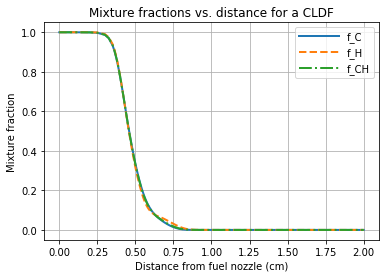

In [31]:
# plot three mixture fraction profiles
fig, ax = plt.subplots()
ax.plot(flame.grid*100., f_C,  '-',  label='f_C',  lw=2)
ax.plot(flame.grid*100., f_H,  '--', label='f_H',  lw=2)
ax.plot(flame.grid*100., f_CH, '-.', label='f_CH', lw=2)

ax.set(xlabel='Distance from fuel nozzle (cm)',
       ylabel='Mixture fraction',
       title ='Mixture fractions vs. distance for a CLDF')
ax.grid(True)
ax.legend(handlelength=4,loc='best')
fig.savefig("f_vs_z_CLDF.pdf")
plt.show()

The mixture fraction decreases monotonically from a value of one in pure fuel to a value of zero in pure oxidizer. The three curves are not quite identical, but it can be seen that they are very similar. To see the differences more clearly, we can plot the differences directly:

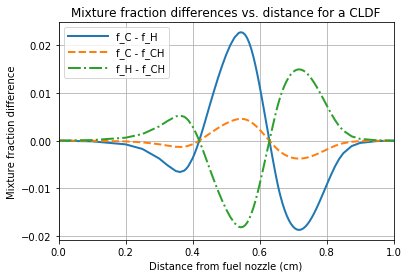

In [32]:
# plot mixture fraction difference profiles
fig, ax = plt.subplots()
ax.plot(flame.grid*100., f_C-f_H,  '-',  label='f_C - f_H',  lw=2)
ax.plot(flame.grid*100., f_C-f_CH, '--', label='f_C - f_CH', lw=2)
ax.plot(flame.grid*100., f_H-f_CH, '-.', label='f_H - f_CH', lw=2)

ax.set(xlim  =(0.0,1.0),
       xlabel='Distance from fuel nozzle (cm)',
       ylabel='Mixture fraction difference',
       title ='Mixture fraction differences vs. distance for a CLDF')
ax.grid(True)
ax.legend(handlelength=4,loc='best')
fig.savefig("df_vs_z_CLDF.pdf")

The difference between f_C and f_CH is small, compared to the difference between f_H and either of the other two. As we saw in tutorial Notebook 7_1_Molecular_transport_properties and tutorial Notebook 8_3_1DLPF_transport, differential diffusion effects are most prominent for low-molecular-weight species such as H and H2, which have much higher diffusivities compared to higher-molecular-weight species. For this reason, it is generally preferable to use f_CH or f_C as a mixture fraction, rather than f_H.

There is also a [`mixture_fraction()`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/onedim.html#cantera.CounterflowDiffusionFlame.mixture_fraction)  attribute than can be used to compute a mixture fraction directly: 

In [33]:
# let's see what "mixture_fraction"
help(flame.mixture_fraction)

Help on method mixture_fraction in module cantera.onedim:

mixture_fraction(m) method of cantera.onedim.CounterflowDiffusionFlame instance
    Compute the mixture fraction based on element *m*
    
    The mixture fraction is computed from the elemental mass fraction of
    element *m*, normalized by its values on the fuel and oxidizer
    inlets:
    
    .. math:: Z = \frac{Z_{\mathrm{mass},m}(z) -
                        Z_{\mathrm{mass},m}(z_\mathrm{oxidizer})}
                       {Z_{\mathrm{mass},m}(z_\mathrm{fuel}) -
                        Z_{\mathrm{mass},m}(z_\mathrm{oxidizer})}
    
    :param m:
        The element based on which the mixture fraction is computed,
        may be specified by name or by index
    
    >>> f.mixture_fraction('H')



That is, "mixture_fraction('C')" is a mixture fraction based on the normalized elemental mass fraction of carbon (equivalent to f_C defined above), and "mixture_fraction('H')" is a mixture fraction based on the normalized elemental mass fraction of hydrogen (equivalent to f_H defined above). We can confirm this as follows:

In [34]:
# compute mixture fractions directly using "mixture_fraction"
mf_C = flame.mixture_fraction('C')
mf_H = flame.mixture_fraction('H')

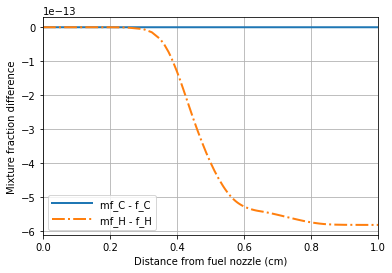

In [35]:
# plot mixture fraction difference profiles
fig, ax = plt.subplots()
ax.plot(flame.grid*100., mf_C-f_C, '-',  label='mf_C - f_C', lw=2)
ax.plot(flame.grid*100., mf_H-f_H, '-.', label='mf_H - f_H', lw=2)

ax.set(xlim  =(0.0,1.0),
       xlabel='Distance from fuel nozzle (cm)',
       ylabel='Mixture fraction difference')
ax.grid(True)
ax.legend(handlelength=4,loc='best')
fig.savefig("df2_vs_z_CLDF.pdf")

The differences are essentially equal to zero, to within machine precision.

### 5.2 Idealized flame structure in mixture-fraction space

As discussed in Chapter 9 of Turns 4th ed. (there in the context of axisymmetric laminar jet diffusion flames), for the idealized case of an adiabatic constant-pressure flame with constant properties, unity Lewis numbers for all species, and infinitely fast chemistry, the species mass fraction and temperature profiles are simple piecewise linear functions of mixture fraction. Moreover, fuel and oxidizer cannot coexist at any location.

The flame structure in mixture-fraction space for this idealized case can then be displayed as follows. Here we make one additional simplification, that the temperatures of the fuel and the oxidizer are the same.

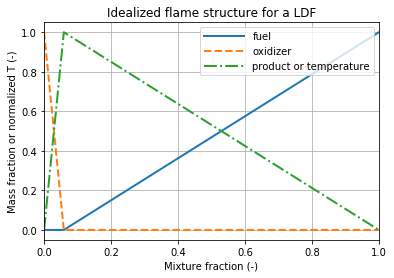

In [36]:
# compute and plot idealized normalized profiles of fuel, oxidizer, and product mass fractions and of temperature
#   as functions of mixture fraction, through a laminar diffusion flame
# Y_F is the fuel mass fraction, normalized by its value in the pure fuel mixture
# Y_O is the oxidizer mass fraction, normalized by its value in the pure oxidizer mixture
# Y_P is a major-species product mass fraction, normalized by its value at the stoichiometric mixture fraction value;
#   this is the same as (T-T_fuel)/(T_max-T_fuel), where T is the local temperature, T_fuel = T_oxid is the temperature
#   of the the pure fuel mixture, which is equal to that of the pure oxidizer mixture, and T_max is the maximum
#   temperature (the constant-pressure adiabatic flame temperature)
# since the profiles are piecewise linear, we need only specify three values for each quantity:
#   the value corresponding to pure oxider (f=0)
#   the value corresponding to pure fuel   (f=1)
#   the value corresponding to fuel and oxidizer in stoichiometric proportion (f=f_stoich)
# recall that the value of f_stoich for the current C2H6-air system was set earlier
f   = [0. , f_stoich , 1.]
Y_F = [0. , 0. , 1.]
Y_O = [1. , 0. , 0.]
Y_P = [0. , 1. , 0.]

fig, ax = plt.subplots()
ax.plot(f, Y_F, '-',  label='fuel',                   lw=2)
ax.plot(f, Y_O, '--', label='oxidizer',               lw=2)
ax.plot(f, Y_P, '-.', label='product or temperature', lw=2)

ax.set(xlim  =(0.0,1.0),
       xlabel='Mixture fraction (-)',
       ylabel='Mass fraction or normalized T (-)',
       title ='Idealized flame structure for a LDF')
ax.grid(True)
ax.legend(handlelength=4,loc='best')
fig.savefig("YT_vs_f_CLDF_idealized.pdf")

This can be compared with Figure 9.8 in Turns 4th ed. Note that with the assumption of infinitely fast chemistry, the heat-release-rate profile (not shown) would be a delta function at the stoichiometric value of the mixture fraction.

### 5.3 Real flame structure in mixture-fraction space

Now let's look at the actual structure of our C2H6-air counterflow laminar diffusion flame, using mixture fraction as the independent variable instead of a spatial coordinate. For this purpose, we will use the elemental-carbon-based mixture fraction. The results would look essentially the same using the elemental-carbon-plus-elemental-hydrogen-based mixture fraction, while some differences might be seen with the elemental-hydrogen-based mixture fraction.

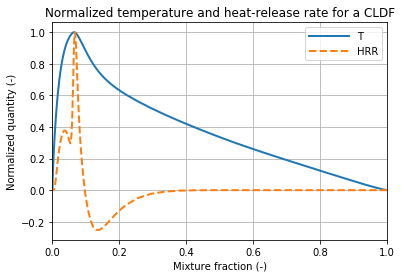

In [37]:
# plot normalized temperature and heat-release rate versus mixture fraction
# each is normalized by its maximum value
# for temperature, the temperature difference with respect to the fuel jet temperature is plotted

# get the maximimum temperature and the maximum heat-release rate
Tmax   = np.max(flame.T)
HRRmax = np.max(flame.heat_release_rate)

fig, ax = plt.subplots()
ax.plot(f_C, (flame.T-flame.T[0])/(Tmax-flame.T[0]), '-',  label='T',   lw=2)
ax.plot(f_C, flame.heat_release_rate/HRRmax,         '--', label='HRR', lw=2)

ax.set(xlim  =(0.0,1.0),
       xlabel='Mixture fraction (-)',
       ylabel='Normalized quantity (-)',
       title ='Normalized temperature and heat-release rate for a CLDF')
ax.grid(True)
ax.legend(handlelength=4,loc='best')
fig.savefig("THRR_vs_f_CLDF.pdf")

The temperature profile is somewhat different from the "triangular" profile from the simplified analysis, but the general trends are similar. For example, the peak temperature occurs at a value of the mixture fraction that is close to the stoichiometric value. The differences arise from a combination of the realistic thermodynamic properties, realistic finite-rate chemistry, and realistic molecular transport that are considered here.

The heat-release rate profile is not a delta function, but it does have a narrow peak that is at a location close to that of the peak temperature. As noted earlier, the heat-release rate is negative on the fuel-rich side.

To see more clearly what is happening around the stoichiometric value of the mixture fraction, let's zoom in:

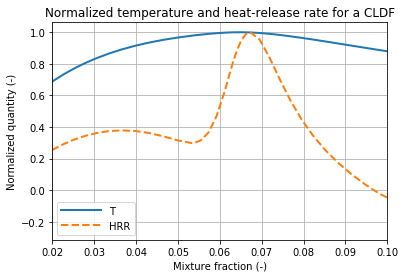

In [38]:
# plot normalized temperature and heat-release rate versus mixture fraction, and zoom in
# each is normalized by its maximum value
# for temperature, the temperature difference with respect to the fuel jet temperature is plotted

fig, ax = plt.subplots()
ax.plot(f_C, (flame.T-flame.T[0])/(Tmax-flame.T[0]), '-',  label='T',   lw=2)
ax.plot(f_C, flame.heat_release_rate/HRRmax,         '--', label='HRR', lw=2)

ax.set(xlim  =(0.02,0.10),
       xlabel='Mixture fraction (-)',
       ylabel='Normalized quantity (-)',
       title ='Normalized temperature and heat-release rate for a CLDF')
ax.grid(True)
ax.legend(handlelength=4,loc='best')
fig.savefig("THRR_vs_f_CLDF_zoom.pdf")

The peak temperature and peak heat-release rate actually occur for a slightly fuel-rich mixture (a mixture-fraction value that is higher than the stoichiometric value of approximately 0.059). This is consistent with our earlier discussion of adiabatic flame temperatures and premixed laminar flame speeds, both of which peak for slightly fuel-rich mixtures. The rounding of the temperature and heat-release-rate profiles in the vicinity of the peak (in contrast the the sharp peaks deduced from the simplified theory) is also evident. 

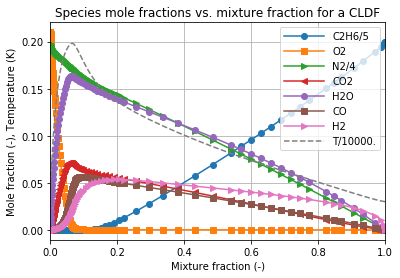

In [39]:
# plot major-species mole fractions as functions of mixture fraction, plus CO and H2
# include temperature, for reference
X_C2H6 = flame.X[gas.species_index('C2H6')]
X_O2   = flame.X[gas.species_index('O2')]
X_N2   = flame.X[gas.species_index('N2')]
X_CO2  = flame.X[gas.species_index('CO2')]
X_H2O  = flame.X[gas.species_index('H2O')]
X_CO   = flame.X[gas.species_index('CO')]
X_H2   = flame.X[gas.species_index('H2')]

fig, ax = plt.subplots()
ax.plot(f_C, X_C2H6/5.,      '-o', label='C2H6/5'  )
ax.plot(f_C, X_O2,           '-s', label='O2'      )
ax.plot(f_C, X_N2/4.,        '->', label='N2/4'    )
ax.plot(f_C, X_CO2,          '-<', label='CO2'     )
ax.plot(f_C, X_H2O,          '-o', label='H2O'     )
ax.plot(f_C, X_CO,           '-s', label='CO'      )
ax.plot(f_C, X_H2,           '->', label='H2'      )
ax.plot(f_C, flame.T/10000., '--', label='T/10000.')

ax.set(xlim  =(0.0,1.0),
       xlabel='Mixture fraction (-)',
       ylabel='Mole fraction (-), Temperature (K)',
       title ='Species mole fractions vs. mixture fraction for a CLDF')
ax.grid(True)
ax.legend(handlelength=4,loc='best')
fig.savefig("Xmajor_vs_f_CLDF.pdf")

The C2H6, O2, CO2, and H2O profiles have shapes that are close to the triangular shapes implied by the simplified theory, and N2 varies nearly linear with mixture fraction. CO and H2 mass fractions peak on the fuel-rich side (mixture fraction value that is higher than the stoichometric value), and are low on the fuel-lean side. Again, we can zoom in to see more clearly what is happening in the vicinity of the stoichiometric value of the mixture fraction:

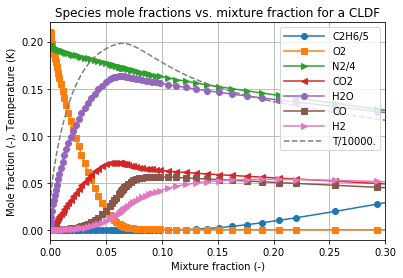

In [40]:
# plot major-species mole fractions as functions of mixture fraction, plus CO and H2
# include temperature, for reference
X_C2H6 = flame.X[gas.species_index('C2H6')]
X_O2   = flame.X[gas.species_index('O2')]
X_N2   = flame.X[gas.species_index('N2')]
X_CO2  = flame.X[gas.species_index('CO2')]
X_H2O  = flame.X[gas.species_index('H2O')]
X_CO   = flame.X[gas.species_index('CO')]
X_H2   = flame.X[gas.species_index('H2')]

fig, ax = plt.subplots()
ax.plot(f_C, X_C2H6/5.,      '-o', label='C2H6/5'  )
ax.plot(f_C, X_O2,           '-s', label='O2'      )
ax.plot(f_C, X_N2/4.,        '->', label='N2/4'    )
ax.plot(f_C, X_CO2,          '-<', label='CO2'     )
ax.plot(f_C, X_H2O,          '-o', label='H2O'     )
ax.plot(f_C, X_CO,           '-s', label='CO'      )
ax.plot(f_C, X_H2,           '->', label='H2'      )
ax.plot(f_C, flame.T/10000., '--', label='T/10000.')

ax.set(xlim  =(0.0,0.3),
       xlabel='Mixture fraction (-)',
       ylabel='Mole fraction (-), Temperature (K)',
       title ='Species mole fractions vs. mixture fraction for a CLDF')
ax.grid(True)
ax.legend(handlelength=4,loc='best')
fig.savefig("Xmajor_vs_f_CLDF_zoom.pdf")

Next, let's look at some of the minor species:

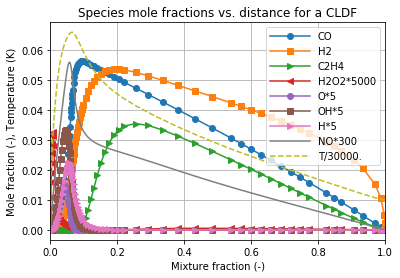

In [41]:
# plot minor-species mole fractions as functions of mixture fraction
# also plot the temperature, for reference
X_CO    = flame.X[gas.species_index('CO')]
X_H2    = flame.X[gas.species_index('H2')]
X_C2H4  = flame.X[gas.species_index('C2H4')]
X_H2O2  = flame.X[gas.species_index('H2O2')]
X_OH    = flame.X[gas.species_index('OH')]
X_O     = flame.X[gas.species_index('O')]
X_H     = flame.X[gas.species_index('H')]
X_NO    = flame.X[gas.species_index('NO')]

fig, ax = plt.subplots()
ax.plot(f_C, X_CO,           '-o', label='CO'       )
ax.plot(f_C, X_H2,           '-s', label='H2'       )
ax.plot(f_C, X_C2H4,         '->', label='C2H4'     )
ax.plot(f_C, X_H2O2*5000.,   '-<', label='H2O2*5000')
ax.plot(f_C, X_O*5.,         '-o', label='O*5'      )
ax.plot(f_C, X_OH*5.,        '-s', label='OH*5'     )
ax.plot(f_C, X_H*5.,         '->', label='H*5'      )
ax.plot(f_C, X_NO*300.,            label='NO*300'   )
ax.plot(f_C, flame.T/30000., '--', label='T/30000.' )

ax.set(xlim  =(0.0,1.0),
       xlabel='Mixture fraction (-)',
       ylabel='Mole fraction (-), Temperature (K)',
       title ='Species mole fractions vs. distance for a CLDF')
ax.grid(True)
ax.legend(handlelength=4,loc='best')
fig.savefig("Xminor_vs_f_CLDF.pdf")

It is difficult to make out what is happening in the vicinity of the stoichiometric value of the mixture fraction, but it can be seen that intermediates such as C2H4 (in addition to CO and H2) peak on the fuel-rich side. Let's zoom in:

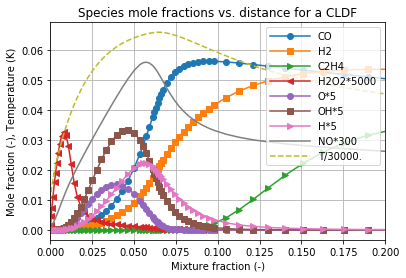

In [42]:
# plot minor-species mole fractions as functions of mixture fraction, zooming in
# also plot the temperature, for reference
X_CO    = flame.X[gas.species_index('CO')]
X_H2    = flame.X[gas.species_index('H2')]
X_C2H4  = flame.X[gas.species_index('C2H4')]
X_H2O2  = flame.X[gas.species_index('H2O2')]
X_OH    = flame.X[gas.species_index('OH')]
X_O     = flame.X[gas.species_index('O')]
X_H     = flame.X[gas.species_index('H')]
X_NO    = flame.X[gas.species_index('NO')]

fig, ax = plt.subplots()
ax.plot(f_C, X_CO,           '-o', label='CO'       )
ax.plot(f_C, X_H2,           '-s', label='H2'       )
ax.plot(f_C, X_C2H4,         '->', label='C2H4'     )
ax.plot(f_C, X_H2O2*5000.,   '-<', label='H2O2*5000')
ax.plot(f_C, X_O*5.,         '-o', label='O*5'      )
ax.plot(f_C, X_OH*5.,        '-s', label='OH*5'     )
ax.plot(f_C, X_H*5.,         '->', label='H*5'      )
ax.plot(f_C, X_NO*300.,            label='NO*300'   )
ax.plot(f_C, flame.T/30000., '--', label='T/30000.' )

ax.set(xlim  =(0.0,0.2),
       xlabel='Mixture fraction (-)',
       ylabel='Mole fraction (-), Temperature (K)',
       title ='Species mole fractions vs. distance for a CLDF')
ax.grid(True)
ax.legend(handlelength=4,loc='best')
fig.savefig("Xminor_vs_f_CLDF_zoom.pdf")

H2O2 peaks far into the fuel-lean side, while O, OH, and H peak slightly into the fuel-lean side. Peak NO occurs slightly to the left (fuel-lean side) of the peak temperature. Recall that oxygen and high temperature are required for thermal NO production.

Finally, we note that there are other definitions of mixture fractions in the literature. The different definitions use various linear combinations of species mass fractions, suitably normalized. The definitions differ in the species that are considered, how they deal with cases where some elements are present in both the fuel and the oxidizer, and other considerations. For example, Bilger's definition (Bilger, Starner and Kee, 1990, Combustion and Flame 80:135-149) is often used to report mixture fractions from experimental measurements, which are typically limited to measuring a small number of molecular species.

## 6. Influence of radiative heat transfer

In real flames, radiative heat transfer takes energy from the high-temperature flame zone to the lower-temperature surroundings, thereby reducing the maximum temperature that is reached in the flame. We will not discuss radiation in any detail here, but will simply repeat the earlier steady-state counterflow laminar diffusion flame calculation, this time allowing for radiative heat transfer, to see what general influence it has.

First, we save the temperature and NO mole fraction profiles from the no-radiation case.

In [43]:
# save the temperature and NO mole fraction profiles from the no-radiation case
T_norad  = flame.T
NO_norad = flame.X[gas.species_index('NO')]

We then enable radiation, and rerun the simulation. Note that the initial condition for the simulation in this case is the converged steady-state solution from the no-radiation case, since we do not reinitialize the system back to the original initial condition. We also disable grid refinement here, since we expect relatively small changes in the computed profiles with consideration of radiation.

In general, restarting from a previous converged solution can be an effective strategy for obtaining converged solutions for conditions that otherwise prove difficult numerically. It also can be possible to obtain converged solutions for difficult cases by performing a succession of steady-state simulations, where small changes in parameters are made from one simulation to the next, and the steady-state solution from the previous simulation is used as the initial condition. 

In [44]:
# enable radiation, and solve again
flame.radiation_enabled = True
flame.solve(loglevel=1, refine_grid=False)

# store the temperature and NO mole fraction profiles with consideration of radiative heat transfer
T_rad  = flame.T
NO_rad = flame.X[gas.species_index('NO')]


..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [98] point grid(s).

..............................................................................
grid refinement disabled.


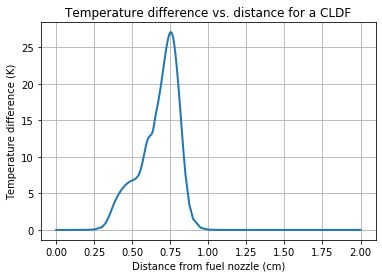

In [45]:
# plot the difference between the steady-state temperature profiles with versus without radiation
fig, ax = plt.subplots()
ax.plot(flame.grid*100., T_norad-T_rad, '-', label='dT', lw=2)

ax.set(xlabel='Distance from fuel nozzle (cm)',
       ylabel='Temperature difference (K)',
       title ='Temperature difference vs. distance for a CLDF')
ax.grid(True)
#ax.legend(handlelength=4,loc='best')
fig.savefig("dT_vs_z_CLDF.pdf")

The computed peak temperature drops by approximately 30 K with consideration of radiative heat transfer.

This is a relatively small temperature drop: less than 2% of the peak temperature. However, as we have discussed, even small differences in temperature can result in relatively large differences in thermal NO, especially for temperatures in the 1800-2000 K range.

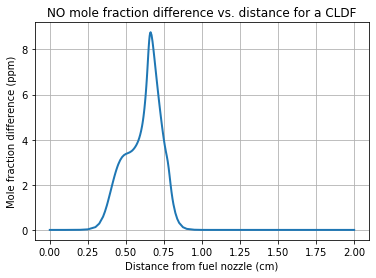

In [46]:
# plot the difference between the steady-state NO mole fraction profiles with versus without radiation, in ppm
fig, ax = plt.subplots()
ax.plot(flame.grid*100., (NO_norad-NO_rad)*1.e+6, '-', label='dNO', lw=2)

ax.set(xlabel='Distance from fuel nozzle (cm)',
       ylabel='Mole fraction difference (ppm)',
       title ='NO mole fraction difference vs. distance for a CLDF')
ax.grid(True)
#ax.legend(handlelength=4,loc='best')
fig.savefig("dNO_vs_z_CLDF.pdf")

The peak NO mole fraction drops by approximately 9 ppm with consideration of radiative heat transfer.

## 7. Parametric study: Flame structure versus strain rate

The spatial structure of a laminar diffusion flame changes significantly with changes in the strain rate. To explore this, we compute a series of flames for different values of the strain rate. The strain rate is not specified directly here, but rather is varied by changing the mass flow rates of fuel and oxidizer: higher flow rates result in higher strain rates, and lower flow rates in lower strain rates. Here we vary the mass flow rates while maintaining a constant ratio of the mass flow rate of oxidizer to the mass flow rate of fuel: the ratio is equal to three.

To keep this section self-contained, we redefine the system from the beginning.

In [47]:
# define the gas mixture
# note that the thermochemical state is reset to the default state
gas = ct.Solution('gri30.cti')

# specify the pressure (constant and uniform) and the fuel and oxidizer boundary conditions
# the fuel and oxidizer mass flow rates are set here to base values that correspond to a relatively low strain rate
# then the base mass flow rates will be multiplied by different constant values to simulate flames with progressively
#   higher strain-rate values

# pressure (constant and uniform)
P = ct.one_atm  # (Pa)

# fuel nozzle
T_fuel         = 300.0              # (K)
X_fuel         = 'C2H6:1'           # mole fractions
mdot_fuel_base = 0.010              # (kg/m^2-s)

# oxidizer nozzle
T_oxid         = 300.0              # (K)
X_oxid         = 'O2:0.21, N2:0.79' # mole fractions
mdot_oxid_base = 0.030              # (kg/m^2-s)

# distance between the fuel and oxidizer nozzles
width = 0.02 # (m)

# create the flame object
flame = ct.CounterflowDiffusionFlame(gas, width=width)

# diable radiative heat transfer
flame.set_boundary_emissivities(0.0, 0.0)
flame.radiation_enabled = False

# specify grid-refinement parameters
flame.set_refine_criteria(ratio=4, slope=0.2, curve=0.3, prune=0.04)

# specify level of output desired
# here all output is suppressed - in case of a convergence failure, you can rerun with a higher value of loglevel
#   to see what is happening
loglevel = 0

# specify the fuel and oxidizer nozzle mixture temperatures and compositions
# these are the same for all cases
flame.fuel_inlet.T     = T_fuel
flame.fuel_inlet.X     = X_fuel
    
flame.oxidizer_inlet.T = T_oxid
flame.oxidizer_inlet.X = X_oxid

In [48]:
# specify the reactant-mass-flow-rate multipliers
mmults = [1., 10., 50., 100.]

# define arrays to store values of various quantitites for different strain rates
a_stoich = np.zeros(len(mmults))
T_max    = np.zeros(len(mmults))
NO_max   = np.zeros(len(mmults))

 
Solution for strain rate 19.17/s required 8.58 s
 
Solution for strain rate 139.04/s required 15.19 s
 
Solution for strain rate 560.47/s required 16.98 s
 
Solution for strain rate 1015.42/s required 22.24 s


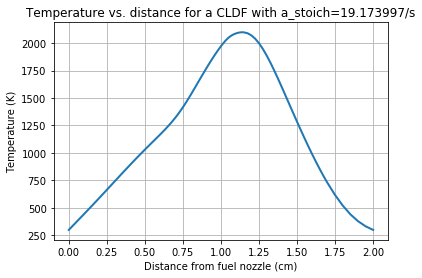

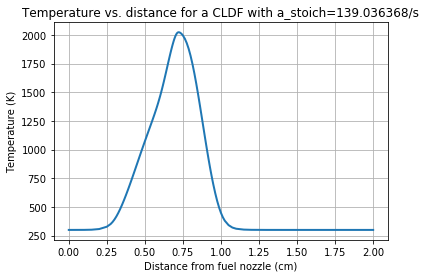

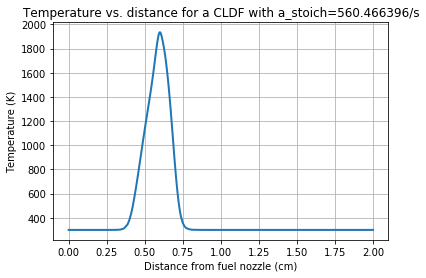

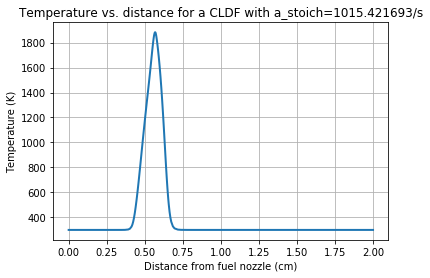

In [49]:
# loop over the reactant-mass-flow-rate multipliers
# the flame is reinitialized to the original six-point grid for each case
for i , mult in enumerate(mmults):
    mdot_fuel = mult*mdot_fuel_base
    mdot_oxid = mult*mdot_oxid_base

# re-initialize the flame
    gas.TPX = 300., P, 'C2H6:1.'
    flame = ct.CounterflowDiffusionFlame(gas, width=width)
    flame.set_boundary_emissivities(0.0, 0.0)
    flame.radiation_enabled = False
    flame.set_refine_criteria(ratio=4, slope=0.2, curve=0.3, prune=0.04)
    flame.fuel_inlet.T     = T_fuel
    flame.fuel_inlet.X     = X_fuel   
    flame.oxidizer_inlet.T = T_oxid
    flame.oxidizer_inlet.X = X_oxid

# reset the fuel and oxidizer mass flow rates
    flame.fuel_inlet.mdot     = mdot_fuel
    flame.oxidizer_inlet.mdot = mdot_oxid

# compute the steady-state solution, and track the computational time
    ctim0 = time.time()
    flame.solve(loglevel=loglevel, auto=True)
    ctim1 = time.time()
    ctime = ctim1 - ctim0

# store the strain rate, peak temperature, and peak NO mole fraction
    a_stoich[i] = flame.strain_rate('stoichiometric', fuel='C2H6', oxidizer='O2')
    T_max[i]    = np.max(flame.T)
    NO_max[i]   = np.max(flame.X[gas.species_index('NO')])

# plot the steady-state temperature profile
    fig, ax = plt.subplots()
    ax.plot(flame.grid*100., flame.T, '-', label='T', lw=2)
    ptitle  = "Temperature vs. distance for a CLDF with a_stoich={:2f}/s".format(a_stoich[i])
    ax.set(xlabel='Distance from fuel nozzle (cm)',
           ylabel='Temperature (K)',
           title = ptitle)
    ax.grid(True)
#    ax.legend(handlelength=4,loc='best')

# print the strain rate (at the stoichiometric location) and computational time required
    print(" ")
    print("Solution for strain rate {:.2f}/s required {:.2f} s".format(a_stoich[i],ctime))

As the mass flow rates increase (corresponding to the increasing strain rate), the temperature profile becomes thinner and the peak temperature decreases.

Converged steady-state solutions were found for all values of the mass flow rates (strain rates) considered here. 

In general, there is a minimum value of the nozzle mass flow rates (or strain rate) for which a converged steady-state solution can be obtained for a given distance between the nozzles (a given value of "width"). For lower values of the strain rate, the profiles would be thicker than the space that is available between the fuel and the oxidizer nozzles. 

It is important to recognize that the thickness of the region over which temperature and composition vary significantly for a laminar diffusion flame depends fundamentally on the externally imposed flow field (strain rate) in which the flame exists. A laminar diffusion flame has no unique characteristic thickness that is independent of the flow field. In contrast, a premixed laminar flame has a characteristic thickness that depends only on the thermochemical state of the reactants, even in the absence of any externally imposed flow.

For mass flow rates (strain rates) that are too high, the chemical reactions cannot keep up the high transport rates, and the flame extinguishes. It can be difficult to obtain converged numerical solutions for strain rates that are close to extinction. We will look at this in the next tutorial Notebook, 9_2_1DCLDF_extinction.

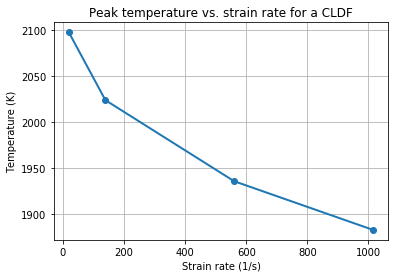

In [50]:
# plot the peak temperature versus strain rate
fig, ax = plt.subplots()
ax.plot(a_stoich, T_max, '-o', label='T', lw=2)

ax.set(xlabel='Strain rate (1/s)',
       ylabel='Temperature (K)',
       title ='Peak temperature vs. strain rate for a CLDF')
ax.grid(True)
#ax.legend(handlelength=4,loc='best')
fig.savefig("Tmax_vs_strainrate_CLDF.pdf")

The peak temperature approaches, but remains lower than, the adiabatic flame temperature as the strain rate decreases toward zero. Presumably, we could get closer to the adiabatic flame temperature by further reducing the strain rate; that would require increasing the distance between the two nozzles (the value of "width").

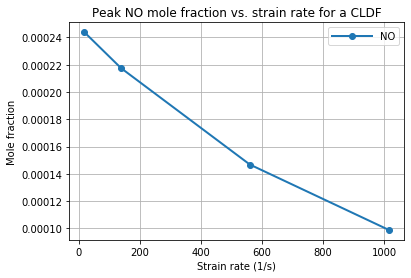

In [51]:
# plot the peak NO mole fraction versus strain rate
fig, ax = plt.subplots()
ax.plot(a_stoich, NO_max, '-o', label='NO', lw=2)

ax.set(xlabel='Strain rate (1/s)',
       ylabel='Mole fraction',
       title ='Peak NO mole fraction vs. strain rate for a CLDF')
ax.grid(True)
ax.legend(handlelength=4,loc='best')
fig.savefig("NOmax_vs_strainrate_CLDF.pdf")

The peak NO mole fraction remains an order of magnitude lower than the equilibrium value for the lowest strain rate considered here. Again, presumably we could get closer to the equilibrium value by further reducing the strain rate; that would require increasing the distance between the two nozzles.

## 8. What's next

Two key points are as follows:

* In contrast to a laminar premixed flame, a laminar diffusion flame has no intrinsic length scale or thickness that is independent of the flow in which it occurs.

* While here we have focused on one particular configuration (a counterflow laminar diffusion flame), the basic flame structure in mixture-fraction space that we introduced and discussed here is relevant for both laminar and turbulent nonpremixed flames in other configurations. That includes the influence of strain rate on flame structure. This is a principal reason why it is advantageous to look at flame structure in terms of mixture fraction, rather than in terms of spatial coordinates.

In the next tutorial Notebook, we will look further at the influence of strain rate on counterflow laminar diffusion flames, including strain rates that are high enough to result in extinction. And in Chapter 13, we will revisit flame structure in mixture-fraction space for turbulent nonpremixed flames.